In [2]:
import pandas as pd
import glob
import numpy as np
# pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

In [14]:
pwd

'C:\\Users\\Cheick Oumar GUEYE\\Université de Technologie de Troyes\\Nicolas MORAND - Fil_rouge'

In [5]:
glob.glob('./Tables_traitees/*')

['./Tables_traitees\\Communes_manquantes.csv',
 './Tables_traitees\\Infos_communes.csv',
 './Tables_traitees\\Infos_communes_avec_prix_estimé.csv',
 './Tables_traitees\\Merge_des_tables_sans_estimation_sans_df_elec&df_carb.csv',
 './Tables_traitees\\Population-Superficie_communes.csv',
 './Tables_traitees\\PrixMoy_m2_avec_code_commune.csv',
 './Tables_traitees\\Stations_carburant_avec_code_commune.csv',
 './Tables_traitees\\Stations_electriques_avec_code_commune.csv',
 './Tables_traitees\\Table_avec_prixM2_estime.csv']

| N° | Dataframe | Description |
| -- | -- | -- |  
| 1. | df_elec | Bornes électriques |
| 2. | df_carb | Stations Carburant | 
| 3. | df_pop | Population et superficie commune | 
| 4. | df_com | Infos communes | 
| 5. | df_commune_immo | Prix au m2 | 
| 6. | df_commune_adj | Communes adjacentes | |
|    | df | Dataframe regroupant pop, com, commune_immo et commune adj |
|    | df_train | =df moins 6000 valeurs, à utiliser pour l'entrainement des modèles, le reste sera pour comparer les estimations |
|    | df_m2 | =df_train filtré par les valeurs qui ont un prix au m2 |
|    | df_ridge | =df_train filtré par les valeurs qui ont un prix au m2 mais aussi filtré par les valeurs non NA de features |

In [6]:
# # Lecture du fichier des tables mergées
# df = pd.read_csv('./Tables_traitees/Merge_des_tables_sans_estimation_sans_df_elec&df_carb.csv',
#                  sep=';',dtype={'3_Code département':str, '3_Code INSEE (commune ou arrondissement)':str, 
#                                 '3_Code EPCI':str, '1_Code INSEE commune':str, '1_Num PDL':str,
#                                 '1_longitude':str, '1_code_commune_n':str, '2_Code INSEE':str,
#                                 '2_code_commune_n':str, '4_Code Postal':str, "5_INSEE_DEP":str, "5_ID":str,
#                                 "5_INSEE_COM":str,"5_code_commune_n":str,"6_insee":str,"4_Code INSEE":str,
#                                 "4_Code Département":str })

In [6]:
# Lecture du fichier des tables mergées avec les estimations m2 déjà enregistrées
df = pd.read_csv('./Tables_traitees/Table_avec_prixM2_estime.csv',
                 sep=';',dtype={'3_Code département':str, '3_Code INSEE (commune ou arrondissement)':str, 
                                '3_Code EPCI':str, '1_Code INSEE commune':str, '1_Num PDL':str,
                                '1_longitude':str, '1_code_commune_n':str, '2_Code INSEE':str,
                                '2_code_commune_n':str, '4_Code Postal':str, "5_INSEE_DEP":str, "5_ID":str,
                                "5_INSEE_COM":str,"5_code_commune_n":str,"6_insee":str,"4_Code INSEE":str,
                                "4_Code Département":str })

In [7]:
df.shape

(36750, 63)

In [25]:
df.columns.to_list()

['3_Code région',
 '3_Nom de la région',
 '3_Code département',
 '3_Code commune',
 '3_Nom de la commune',
 '3_Population municipale',
 '3_Population comptée à part',
 '3_Population totale',
 '3_Année recensement',
 '3_Année utilisation',
 '3_Code INSEE (commune ou arrondissement)',
 '3_Superficie de la commune',
 '3_Statut',
 '3_Code EPCI',
 '3_EPCI',
 '3_Densité_hab_par_km2',
 '5_ID',
 '5_INSEE_COM',
 '5_INSEE_DEP',
 '5_INSEE_REG',
 '5_CODE_EPCI',
 '5_NOM_COM_M',
 '5_POPULATION',
 '5_Nb_Ventes',
 '5_PrixMoyen_M2',
 '5_nb_digits_code_INSEE',
 '5_code_commune_n',
 '4_Code INSEE',
 '4_Code Postal',
 '4_Commune',
 '4_Département',
 '4_Région',
 '4_Statut',
 '4_Altitude Moyenne',
 '4_Superficie',
 '4_Population',
 '4_geo_point_2d',
 '4_geo_shape',
 '4_ID Geofla',
 '4_Code Commune',
 '4_Code Canton',
 '4_Code Arrondissement',
 '4_Code Département',
 '4_Code Région',
 '4_lat',
 '4_lon',
 '4_Densité_hab_par_km2',
 '6_insee',
 '6_nom',
 '6_nb_voisins',
 '6_insee_voisins',
 '6_noms_voisins',
 

In [18]:
df.shape

(36750, 63)

In [19]:
# Valeurs uniques et manquant par colonne
df_analyse = []
manquantes = df.isna().sum()
for t in df.columns:
    row = {}
    row['Variable']=t
    row['type']= df[t].dtypes
    row['Nb_val_unique']=len(df[t].unique())
    row['Nb_manquant']=manquantes[t]
    df_analyse.append(row)
df_analyse = pd.DataFrame(df_analyse)
df_analyse.sort_values(by='Nb_manquant',ascending=False)

Variable     type  Nb_val_unique  Nb_manquant
53                     6_type   object              9        35990
23                5_Nb_Ventes  float64            554         9928
24             5_PrixMoyen_M2  float64           3709         9928
57  B_Prix_estimé_vois_median  float64           9337         2351
55    A_Prix_estimé_vois_mean  float64          29371         2351
..                        ...      ...            ...          ...
8         3_Année recensement    int64             10            0
9         3_Année utilisation    int64             10            0
12                   3_Statut   object              2            0
1          3_Nom de la région   object             36            0
0               3_Code région  float64             34            0

[63 rows x 4 columns]

In [12]:
# correction d'une ligne (la seule, dont la superficie et la densité n'étaient pas remplies
df.loc[31441, '3_Superficie de la commune'] = 8.71
df.loc[31441, '3_Densité_hab_par_km2'] = 254.0/8.71
# df.loc[31441,:]

- Choisissons d'abord une liste d'index de 6000 valeurs
- Nous n'utiliserons pas ces lignes pour les entrainements de modèles de ML, uniquement pour mesurer la précision de chaque modèle
- SVP pour entrainer vos modèles, utiliser désormais df_train
- Ensuite vous faites la prédictions sur tout le dataframe df
- Pour la comparaison on utilisera que les lignes correspondantes aux index_to_remove, ainsi on peut comparer les résultats sur des données non entrainées

In [11]:
np.random.seed(97)
index_to_remove = np.random.randint(0,len(df)+1, size=6000)
df_train = df.drop(index_to_remove)

In [12]:
df_m2 = df_train[df_train['5_PrixMoyen_M2'].isna()==False]
# df_m2[sel_col]

In [26]:
df_m2.columns

Index(['3_Code région', '3_Nom de la région', '3_Code département',
       '3_Code commune', '3_Nom de la commune', '3_Population municipale',
       '3_Population comptée à part', '3_Population totale',
       '3_Année recensement', '3_Année utilisation',
       '3_Code INSEE (commune ou arrondissement)',
       '3_Superficie de la commune', '3_Statut', '3_Code EPCI', '3_EPCI',
       '3_Densité_hab_par_km2', '5_ID', '5_INSEE_COM', '5_INSEE_DEP',
       '5_INSEE_REG', '5_CODE_EPCI', '5_NOM_COM_M', '5_POPULATION',
       '5_Nb_Ventes', '5_PrixMoyen_M2', '5_nb_digits_code_INSEE',
       '5_code_commune_n', '4_Code INSEE', '4_Code Postal', '4_Commune',
       '4_Département', '4_Région', '4_Statut', '4_Altitude Moyenne',
       '4_Superficie', '4_Population', '4_geo_point_2d', '4_geo_shape',
       '4_ID Geofla', '4_Code Commune', '4_Code Canton',
       '4_Code Arrondissement', '4_Code Département', '4_Code Région', '4_lat',
       '4_lon', '4_Densité_hab_par_km2', '6_insee', '6_nom', '

In [16]:
from sklearn.model_selection import KFold
nb_kfold = 5
rdm_state = 97
kf = KFold(n_splits=nb_kfold,shuffle=True, random_state = rdm_state)

# Estimation des manquants prix moyen m2 

On commence par choisir les variables qui vont participer à l'imputation

In [17]:
sel_col = ['3_Code INSEE (commune ou arrondissement)','3_Code département', '5_PrixMoyen_M2', 
           'A_Prix_estimé_vois_mean', 'A_Prix_consolidé_vois_mean', 'B_Prix_estimé_vois_median', 'B_Prix_consolidé_vois_median', 
           '6_insee_voisins']

## A-Par moyenne et B-médiane des communes avoisinantes

In [18]:
# On initialise les nouvelles variables
df['A_Prix_consolidé_vois_mean'] = np.nan
df['A_Prix_estimé_vois_mean'] = np.nan
df['B_Prix_consolidé_vois_median'] = np.nan
df['B_Prix_estimé_vois_median'] = np.nan
df['5_PrixMoyen_M2'] = df['5_PrixMoyen_M2'].astype(float)

In [19]:
# On crée un dictionnaire pour aller plus vite dans la recherche des communes voisines 
voisins_dict = df.set_index('6_insee')['6_insee_voisins'].to_dict()
df['A_Prix_consolidé_vois_mean'] = df['5_PrixMoyen_M2']
df['B_Prix_consolidé_vois_median'] = df['5_PrixMoyen_M2']

In [20]:
def estim_prix(code, vois, prix_mean, prix_median):
    try:
        # voisins = df_commune_adj.loc[df_commune_adj['insee']==code,'insee_voisins'].values[0].split('|')
        voisins = vois[str(code)].split('|')
        # print(voisins)
        prix_voisins_mean = list()
        prix_voisins_median = list()
        for v in voisins:
            try:
                # p = df.loc[df['Code INSEE (commune ou arrondissement)']==v,'Prix_consolidé'].values[0]
                p1 = prix_mean[str(v)]
                p2 = prix_median[str(v)]
            except:
                p1, p2 = None, None
            # nb = df.loc[df['Code INSEE (commune ou arrondissement)']==v,'Nb_Ventes'].values[0]
            prix_voisins_mean.append(float(p1))
            prix_voisins_median.append(float(p2))
        # print(code, voisins,prix_voisins)
        mean = np.nanmean(prix_voisins_mean)
        median = np.nanmedian(prix_voisins_median)
    except:
        mean = np.nan
        median = np.nan
    # print(code, mean, median)
    # print('-------')
    return pd.Series({'A_Prix_estimé_vois_mean': mean, 'B_Prix_estimé_vois_median': median})

In [21]:
%%time
n_iterations = 10
i=0
print('iteration:',i,'nbre de manquants:', sum(pd.isna(df['A_Prix_consolidé_vois_mean'])))
while i<n_iterations:
    Prix_consolidé_dict_mean = df.set_index('3_Code INSEE (commune ou arrondissement)')['A_Prix_consolidé_vois_mean'].to_dict()
    Prix_consolidé_dict_median = df.set_index('3_Code INSEE (commune ou arrondissement)')['B_Prix_consolidé_vois_median'].to_dict()
    df[['A_Prix_estimé_vois_mean', 'B_Prix_estimé_vois_median']] = df.apply(lambda x: estim_prix(x['3_Code INSEE (commune ou arrondissement)'], 
                                                                                      voisins_dict, Prix_consolidé_dict_mean, 
                                                                                       Prix_consolidé_dict_median ),axis=1)
    df['A_Prix_consolidé_vois_mean'] = df['A_Prix_estimé_vois_mean']
    df['B_Prix_consolidé_vois_median'] = df['B_Prix_estimé_vois_median']
    df.loc[pd.notna(df['5_PrixMoyen_M2']),'A_Prix_consolidé_vois_mean'] = df.loc[pd.notna(df['5_PrixMoyen_M2']), '5_PrixMoyen_M2'] 
    df.loc[pd.notna(df['5_PrixMoyen_M2']),'B_Prix_consolidé_vois_median'] = df.loc[pd.notna(df['5_PrixMoyen_M2']), '5_PrixMoyen_M2'] 
    nb_manquants = sum(pd.isna(df['A_Prix_consolidé_vois_mean']))
    i+=1
    print('iteration:',i,'nbre de manquants:',nb_manquants)

iteration: 0 nbre de manquants: 9928


C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered


iteration: 1 nbre de manquants: 4075


C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered


iteration: 2 nbre de manquants: 3495


C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered


iteration: 3 nbre de manquants: 3238


C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered


iteration: 4 nbre de manquants: 3047


C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered


iteration: 5 nbre de manquants: 2868


C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered


iteration: 6 nbre de manquants: 2713


C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered


iteration: 7 nbre de manquants: 2557


C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered


iteration: 8 nbre de manquants: 2424


C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered


iteration: 9 nbre de manquants: 2317


C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\2398426113.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(prix_voisins_mean)
C:\Users\Cheick Oumar GUEYE\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered


iteration: 10 nbre de manquants: 2234
CPU times: total: 2min 26s
Wall time: 5min 56s


In [22]:
df_prix_na = df[df['A_Prix_consolidé_vois_mean'].isna()]

In [23]:
df_prix_na.shape

(2234, 63)

In [24]:
print(len(df_prix_na.loc[pd.isna(df_prix_na['6_insee_voisins']),sel_col]))
df_prix_na.loc[pd.isna(df_prix_na['6_insee_voisins']),sel_col]

1750


3_Code INSEE (commune ou arrondissement) 3_Code département  \
53                                       01059                 01   
83                                       01091                 01   
89                                       01097                 01   
111                                      01119                 01   
113                                      01122                 01   
...                                        ...                ...   
36183                                    91222                 91   
36510                                    95259                 95   
36630                                    97110                971   
36648                                    97130                971   
36649                                    97131                971   

       5_PrixMoyen_M2  A_Prix_estimé_vois_mean  A_Prix_consolidé_vois_mean  \
53                NaN                      NaN                         NaN   
83                NaN                      NaN                         NaN   
89                NaN                      NaN                         NaN   
111               NaN                      NaN                         NaN   
113               NaN                      NaN                         NaN   
...               ...                      ...                         ...   
36183             NaN                      NaN                         NaN   
36510             NaN                      NaN                         NaN   
36630             NaN                      NaN                         NaN   
36648             NaN                      NaN                         NaN   
36649             NaN                      NaN                         NaN   

       B_Prix_estimé_vois_median  B_Prix_consolidé_vois_median 6_insee_voisins  
53                           NaN                           NaN             NaN  
83                           NaN                           NaN             NaN  
89                           NaN                           NaN             NaN  
111                          NaN                           NaN             NaN  
113                          NaN                           NaN             NaN  
...                          ...                           ...             ...  
36183                        NaN                           NaN             NaN  
36510                        NaN                           NaN             NaN  
36630                        NaN                           NaN             NaN  
36648                        NaN                           NaN             NaN  
36649                        NaN                           NaN             NaN  

[1750 rows x 8 columns]

In [25]:
print(len(df_prix_na.loc[~pd.isna(df_prix_na['6_insee_voisins']),sel_col]))
df_prix_na.loc[~pd.isna(df_prix_na['6_insee_voisins']),sel_col]

484


3_Code INSEE (commune ou arrondissement) 3_Code département  \
22033                                    57006                 57   
22040                                    57013                 57   
22043                                    57016                 57   
22072                                    57046                 57   
22084                                    57058                 57   
...                                        ...                ...   
36745                                    97613                976   
36746                                    97614                976   
36747                                    97615                976   
36748                                    97616                976   
36749                                    97617                976   

       5_PrixMoyen_M2  A_Prix_estimé_vois_mean  A_Prix_consolidé_vois_mean  \
22033             NaN                      NaN                         NaN   
22040             NaN                      NaN                         NaN   
22043             NaN                      NaN                         NaN   
22072             NaN                      NaN                         NaN   
22084             NaN                      NaN                         NaN   
...               ...                      ...                         ...   
36745             NaN                      NaN                         NaN   
36746             NaN                      NaN                         NaN   
36747             NaN                      NaN                         NaN   
36748             NaN                      NaN                         NaN   
36749             NaN                      NaN                         NaN   

       B_Prix_estimé_vois_median  B_Prix_consolidé_vois_median  \
22033                        NaN                           NaN   
22040                        NaN                           NaN   
22043                        NaN                           NaN   
22072                        NaN                           NaN   
22084                        NaN                           NaN   
...                          ...                           ...   
36745                        NaN                           NaN   
36746                        NaN                           NaN   
36747                        NaN                           NaN   
36748                        NaN                           NaN   
36749                        NaN                           NaN   

                                 6_insee_voisins  
22033  57261|57083|57201|57355|57748|57745|57750  
22040              57260|57408|57360|57202|57659  
22043                    57516|57110|57700|57106  
22072  57541|67340|67358|67265|67392|57489|57188  
22084        57202|57360|57101|57222|57521|57227  
...                                          ...  
36745                          97602|97617|97601  
36746        97611|97607|97606|97616|97605|97617  
36747                                      97608  
36748                          97614|97606|97605  
36749        97610|97611|97614|97605|97613|97602  

[484 rows x 8 columns]

In [26]:
df_prix_na.loc[~pd.isna(df_prix_na['6_insee_voisins']),'3_Code département'].unique()

array(['57', '67', '68', '971', '972', '973', '974', '976'], dtype=object)

2 cas pour ceux qui n'ont pas de prix consolidé
- soit ils n'ont pas de voisins identifiés
- soit ils ont des voisins mais n'ont pas de prix, en DOM TOM, départements 97X

In [27]:
# Ceux qui n'ont pas de prix estimé parce les voisins n'en n'ont pas
df_na = df[df['A_Prix_estimé_vois_mean'].isna() & df['6_insee_voisins'].notna()]
len(df_na)
df_na[:3]

3_Code région          3_Nom de la région 3_Code département  \
4405           93.0  Provence-Alpes-Côte d'Azur                 13   
4408           93.0  Provence-Alpes-Côte d'Azur                 13   
4425           93.0  Provence-Alpes-Côte d'Azur                 13   

      3_Code commune 3_Nom de la commune  3_Population municipale  \
4405             2.0             Allauch                  21228.0   
4408             5.0             Aubagne                  45290.0   
4425            22.0              Cassis                   7162.0   

      3_Population comptée à part  3_Population totale  3_Année recensement  \
4405                        256.0              21484.0                 2016   
4408                        421.0              45711.0                 2016   
4425                        103.0               7265.0                 2016   

      3_Année utilisation  ... 6_type  A_Prix_consolidé_vois_mean  \
4405                 2019  ...    NaN                      3731.0   
4408                 2019  ...    NaN                      3046.0   
4425                 2019  ...    NaN                      6303.0   

     A_Prix_estimé_vois_mean B_Prix_consolidé_vois_median  \
4405                     NaN                       3731.0   
4408                     NaN                       3046.0   
4425                     NaN                       6303.0   

     B_Prix_estimé_vois_median  C_Prix_estime_mean C1_Prix_estime_median  \
4405                       NaN              1636.0                1450.0   
4408                       NaN              1636.0                1450.0   
4425                       NaN              1636.0                1450.0   

     F_Prix_estimé_RFReg G_Prix_estimé_LassoCV  F_Prix_estimé_RFReg2  
4405         3223.939101           3210.706946           3713.790522  
4408         3046.551369           3376.868423           3275.892080  
4425         3635.166727           3177.872351           4291.834576  

[3 rows x 63 columns]

In [28]:
print(len(df[df['5_PrixMoyen_M2'].isna()]))
print(len(df[df['A_Prix_consolidé_vois_mean'].isna()]))
print(len(df[df['B_Prix_consolidé_vois_median'].isna()]))

9928
2234
2234


In [16]:
df[df['A_Prix_estimé_vois_mean'].isna() & df['A_Prix_consolidé_vois_mean'].notna()].head()

3_Code région          3_Nom de la région 3_Code département  \
4405           93.0  Provence-Alpes-Côte d'Azur                 13   
4408           93.0  Provence-Alpes-Côte d'Azur                 13   
4425           93.0  Provence-Alpes-Côte d'Azur                 13   
4472           93.0  Provence-Alpes-Côte d'Azur                 13   
4473           93.0  Provence-Alpes-Côte d'Azur                 13   

      3_Code commune    3_Nom de la commune  3_Population municipale  \
4405             2.0                Allauch                  21228.0   
4408             5.0                Aubagne                  45290.0   
4425            22.0                 Cassis                   7162.0   
4472            70.0  La Penne-sur-Huveaune                   6433.0   
4473            71.0    Les Pennes-Mirabeau                  21361.0   

      3_Population comptée à part  3_Population totale  3_Année recensement  \
4405                        256.0              21484.0                 2016   
4408                        421.0              45711.0                 2016   
4425                        103.0               7265.0                 2016   
4472                         60.0               6493.0                 2016   
4473                        276.0              21637.0                 2016   

      3_Année utilisation  ... A_Prix_consolidé_vois_mean  \
4405                 2019  ...                     3731.0   
4408                 2019  ...                     3046.0   
4425                 2019  ...                     6303.0   
4472                 2019  ...                     3486.0   
4473                 2019  ...                     3457.0   

      A_Prix_estimé_vois_mean B_Prix_consolidé_vois_median  \
4405                      NaN                       3731.0   
4408                      NaN                       3046.0   
4425                      NaN                       6303.0   
4472                      NaN                       3486.0   
4473                      NaN                       3457.0   

     B_Prix_estimé_vois_median C_Prix_estime_mean  C1_Prix_estime_median  \
4405                       NaN             1636.0                 1450.0   
4408                       NaN             1636.0                 1450.0   
4425                       NaN             1636.0                 1450.0   
4472                       NaN             1636.0                 1450.0   
4473                       NaN             1636.0                 1450.0   

     F_Prix_estimé_RFReg G_Prix_estimé_LassoCV F_Prix_estimé_RFReg2  \
4405         3223.939101           3210.706946          3713.790522   
4408         3046.551369           3376.868423          3275.892080   
4425         3635.166727           3177.872351          4291.834576   
4472         3529.964141           3407.809179          3582.240807   
4473         3225.796902           3259.620376          3532.234372   

      D_Prix_estime_KNN  
4405             3731.0  
4408                NaN  
4425                NaN  
4472                NaN  
4473             3457.0  

[5 rows x 64 columns]

In [30]:
df_m2['A_Prix_estimé_vois_mean'] = df['A_Prix_estimé_vois_mean'][df['5_PrixMoyen_M2'].isna() == False]
df_m2['B_Prix_estimé_vois_median'] = df['B_Prix_estimé_vois_median'][df['5_PrixMoyen_M2'].isna() == False]

C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\1286982777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m2['A_Prix_estimé_vois_mean'] = df['A_Prix_estimé_vois_mean'][df['5_PrixMoyen_M2'].isna() == False]
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_18236\1286982777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m2['B_Prix_estimé_vois_median'] = df['B_Prix_estimé_vois_median'][df['5_PrixMoyen_M2'].isna() == False]


In [10]:
df_m2.shape

NameError: name 'df_m2' is not defined

## C-Par moyenne et C1-mediane de toute la variable PAUL

In [32]:
df['5_PrixMoyen_M2'].describe()

count    26822.000000
mean      1635.830177
std        864.263847
min        350.000000
25%       1101.000000
50%       1449.500000
75%       1933.000000
max      14803.000000
Name: 5_PrixMoyen_M2, dtype: float64

In [33]:
mean_value =  np.round(np.mean(df.loc[df['5_PrixMoyen_M2'].isna() == False, '5_PrixMoyen_M2']))
mean_value

1636.0

In [34]:
median_value = np.round(np.median(df.loc[df['5_PrixMoyen_M2'].isna() == False, '5_PrixMoyen_M2']))
median_value

1450.0

In [35]:
df_m2.loc[df['5_PrixMoyen_M2'].isna() == False,'C_Prix_estime_mean'] = mean_value
df_m2.loc[df['5_PrixMoyen_M2'].isna() == False,'C1_Prix_estime_median'] = median_value
df.loc[df['5_PrixMoyen_M2'].isna() == False,'C_Prix_estime_mean'] = mean_value
df.loc[df['5_PrixMoyen_M2'].isna() == False,'C1_Prix_estime_median'] = median_value
df_m2.shape

(22801, 63)

## D-Par KNN OUMAR

In [61]:
# import pandas as pd
# from sklearn.impute import KNNImputer
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# # Sélection des caractéristiques
# features = ['3_Population municipale','5_PrixMoyen_M2', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']

# # Création d'un DataFrame avec seulement les caractéristiques sélectionnées
# data_subset = df[features]

# # Remplacer les valeurs manquantes dans "5_PrixMoyen_M2" par NaN
# data_subset['5_PrixMoyen_M2'] = data_subset['5_PrixMoyen_M2'].replace(0, np.nan)  # Assurez-vous de choisir la valeur qui représente une valeur manquante
# data_subset['5_PrixMoyen_M2'] = pd.to_numeric(data_subset['5_PrixMoyen_M2'], errors='coerce')

# # Imputer les valeurs manquantes avec KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# data_imputed = imputer.fit_transform(data_subset)

# # Normalisation des données
# scaler = MinMaxScaler()
# data_normalized = scaler.fit_transform(data_imputed)

# # Créer un DataFrame avec les données normalisées et le nom des colonnes
# columns = data_subset.columns
# data_normalized_df = pd.DataFrame(data_normalized, columns=columns)

# # Ajouter une colonne pour stocker les valeurs prédites par le KNN
# data_normalized_df['0_KNN_predicted'] = imputer.transform(data_subset)[:, 1]

# # Afficher toutes les données
# print(data_normalized_df)

# #df.loc[df['5_PrixMoyen_M2'].isna() == False,'D_Prix_estime_KNN'] = 0_KNN_predicted


In [47]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Sélection des caractéristiques
features = ['3_Population municipale', '5_PrixMoyen_M2', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie', '4_Altitude Moyenne', '4_lat', '4_lon']

# Création d'un DataFrame avec seulement les caractéristiques sélectionnées dans df_m2
data_subset_m2 = df_m2[features]

# Remplacer les valeurs manquantes dans "5_PrixMoyen_M2" par NaN
data_subset_m2['5_PrixMoyen_M2'] = data_subset_m2['5_PrixMoyen_M2'].replace(0, np.nan)
data_subset_m2['5_PrixMoyen_M2'] = pd.to_numeric(data_subset_m2['5_PrixMoyen_M2'], errors='coerce')

# Imputer les valeurs manquantes avec KNNImputer
imputer = KNNImputer(n_neighbors=5)
data_imputed_m2 = imputer.fit_transform(data_subset_m2)

# Normalisation des données
scaler = MinMaxScaler()
data_normalized_m2 = scaler.fit_transform(data_imputed_m2)

# Ajouter une colonne pour stocker les valeurs prédites par le KNN dans le DataFrame df_m2
df_m2['D_Prix_estime_KNN'] = data_imputed_m2[:, 1]

# Ajouter une colonne pour stocker les valeurs prédites par le KNN dans le DataFrame df
df.loc[df['5_PrixMoyen_M2'].notna(), 'D_Prix_estime_KNN'] = df_m2.loc[df['5_PrixMoyen_M2'].notna(), 'D_Prix_estime_KNN']

# Afficher les premières lignes du DataFrame df_m2 avec la nouvelle colonne ajoutée
print(df_m2.head())


C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_10896\1420691528.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset_m2['5_PrixMoyen_M2'] = data_subset_m2['5_PrixMoyen_M2'].replace(0, np.nan)
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_10896\1420691528.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset_m2['5_PrixMoyen_M2'] = pd.to_numeric(data_subset_m2['5_PrixMoyen_M2'], errors='coerce')


   3_Code région    3_Nom de la région 3_Code département  3_Code commune  \
0           84.0  Auvergne-Rhône-Alpes                 01             1.0   
1           84.0  Auvergne-Rhône-Alpes                 01             2.0   
2           84.0  Auvergne-Rhône-Alpes                 01             4.0   
3           84.0  Auvergne-Rhône-Alpes                 01             5.0   
4           84.0  Auvergne-Rhône-Alpes                 01             6.0   

        3_Nom de la commune  3_Population municipale  \
0  L' Abergement-Clémenciat                    767.0   
1    L' Abergement-de-Varey                    243.0   
2         Ambérieu-en-Bugey                  14081.0   
3       Ambérieux-en-Dombes                   1671.0   
4                   Ambléon                    110.0   

   3_Population comptée à part  3_Population totale  3_Année recensement  \
0                         18.0                785.0                 2016   
1                          1.0                24

In [31]:
len(df)


36750

In [32]:
len(df_m2)

22801

In [97]:
df['5_PrixMoyen_M2']

0        1938.0
1        1130.0
2        2005.0
3        2442.0
4        1155.0
          ...  
36745       NaN
36746       NaN
36747       NaN
36748       NaN
36749       NaN
Name: 5_PrixMoyen_M2, Length: 36750, dtype: float64

In [38]:
data_normalized_df['0_KNN_predicted']

0        1938.0
1        1130.0
2        2005.0
3        2442.0
4        1155.0
          ...  
36745    1682.2
36746    2079.4
36747    3280.6
36748    2536.0
36749    1576.0
Name: 0_KNN_predicted, Length: 36750, dtype: float64

In [79]:
# Vérifier les valeurs manquantes dans la colonne d'origine
missing_values_before = df['5_PrixMoyen_M2'].isnull().sum()
print(f"Nombre de valeurs manquantes dans '5_PrixMoyen_M2' avant l'imputation : {missing_values_before}")

# Imputer les valeurs manquantes avec KNNImputer dans le DataFrame d'origine
df['5_PrixMoyen_M2'] = imputer.transform(df[features])[:, 1]

# Vérifier à nouveau les valeurs manquantes après l'imputation
missing_values_after = df['5_PrixMoyen_M2'].isnull().sum()
print(f"Nombre de valeurs manquantes dans '5_PrixMoyen_M2' après l'imputation : {missing_values_after}")

Nombre de valeurs manquantes dans '5_PrixMoyen_M2' avant l'imputation : 9928


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 5_PrixMoyen_M2


In [40]:
import matplotlib.pyplot as plt

# Extraire les valeurs réelles et prédites
actual_values = data_subset['5_PrixMoyen_M2'].values
predicted_values = data_normalized_df['5_PrixMoyen_M2_predicted'].values

# Créer un graphique de dispersion
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', linewidth=2)
plt.title('Valeurs Réelles vs Valeurs Prédites')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.show()


KeyError: '5_PrixMoyen_M2_predicted'

In [41]:
import matplotlib.pyplot as plt

# Extraire les valeurs réelles et prédites
actual_values = data_subset['5_PrixMoyen_M2'].values
predicted_values = data_normalized_df['5_PrixMoyen_M2_predicted'].values

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist([actual_values, predicted_values], bins=30, label=['Réel', 'Prédit'], alpha=0.7)
plt.legend()
plt.title('Histogramme des Valeurs Réelles et Prédites')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()


KeyError: '5_PrixMoyen_M2_predicted'

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extraire les valeurs réelles et prédites
actual_values = data_subset['5_PrixMoyen_M2'].values
predicted_values = data_normalized_df['5_PrixMoyen_M2_predicted'].values

# Créer un DataFrame pour Seaborn
data_for_seaborn = pd.DataFrame({'Réel': actual_values, 'Prédit': predicted_values})

# Créer un histogramme avec Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=data_for_seaborn, bins=30, kde=True)
plt.title('Histogramme des Valeurs Réelles et Prédites avec Seaborn')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.show()


KeyError: '5_PrixMoyen_M2_predicted'

In [43]:
Delta= y_test - Y_pred

NameError: name 'y_test' is not defined

In [76]:
df.columns

Index(['3_Code région', '3_Nom de la région', '3_Code département',
       '3_Code commune', '3_Nom de la commune', '3_Population municipale',
       '3_Population comptée à part', '3_Population totale',
       '3_Année recensement', '3_Année utilisation',
       '3_Code INSEE (commune ou arrondissement)',
       '3_Superficie de la commune', '3_Statut', '3_Code EPCI', '3_EPCI',
       '3_Densité_hab_par_km2', '5_ID', '5_INSEE_COM', '5_INSEE_DEP',
       '5_INSEE_REG', '5_CODE_EPCI', '5_NOM_COM_M', '5_POPULATION',
       '5_Nb_Ventes', '5_PrixMoyen_M2', '5_nb_digits_code_INSEE',
       '5_code_commune_n', '4_Code INSEE', '4_Code Postal', '4_Commune',
       '4_Département', '4_Région', '4_Statut', '4_Altitude Moyenne',
       '4_Superficie', '4_Population', '4_geo_point_2d', '4_geo_shape',
       '4_ID Geofla', '4_Code Commune', '4_Code Canton',
       '4_Code Arrondissement', '4_Code Département', '4_Code Région', '4_lat',
       '4_lon', '4_Densité_hab_par_km2', '6_insee', '6_nom', '

## E-Par KNeighborsRegressor OUMAR

In [65]:
# from sklearn.neighbors import KNeighborsRegressor 

# data1=df[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon','5_PrixMoyen_M2']]
# data1=data1.dropna()
# data2=data1.sample(n=data1.shape[0],random_state=1)


# data_train= data2[:16819]
# data_test= data2[16820:data1.shape[0]]

# X_train = data_train[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']]
# y_train=data_train[['5_PrixMoyen_M2']]
# X_test = data_test[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']]
# y_test =data_test[['5_PrixMoyen_M2']]
# neigh = KNeighborsRegressor(n_neighbors=50)

# neigh.fit(X_train, y_train)





In [64]:
# import pandas as pd
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.impute import KNNImputer
# import numpy as np

# # Réinitialisez df_m2 avec les données originales (data_original)
# df_m2 = df.copy()

# # Création du DataFrame df avec les caractéristiques nécessaires
# data1 = df[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie', '4_Altitude Moyenne', '4_lat', '4_lon', '5_PrixMoyen_M2']]
# data1 = data1.dropna()

# X_train = data1[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie', '4_Altitude Moyenne', '4_lat', '4_lon']]
# y_train = data1['5_PrixMoyen_M2']

# # Entraînement du modèle KNeighborsRegressor
# neigh = KNeighborsRegressor(n_neighbors=50)
# neigh.fit(X_train, y_train)

# # Remplissage de la colonne 'E_Prix_estime_KNN_R' dans df_m2
# rows_with_missing_values = df_m2['5_PrixMoyen_M2'].isnull()
# X_to_predict = df_m2[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie', '4_Altitude Moyenne', '4_lat', '4_lon']].copy()

# # Réinitialiser les indices pour éviter les problèmes d'assignation
# X_to_predict.reset_index(drop=True, inplace=True)

# # Imputer les valeurs manquantes dans X_to_predict uniquement s'il y a des lignes à imputer
# if not X_to_predict.empty:
#     imputer = KNNImputer(n_neighbors=5)
#     X_to_predict_imputed = imputer.fit_transform(X_to_predict)
    
#     # Faites les prédictions avec le modèle KNeighborsRegressor sur les données imputées
#     predicted_values = neigh.predict(X_to_predict_imputed)

#     # Créer la colonne 'E_Prix_estime_KNN_R' si elle n'existe pas
#     if 'E_Prix_estime_KNN_R' not in df_m2.columns:
#         df_m2['E_Prix_estime_KNN_R'] = np.nan

#     # Utiliser la méthode numpy.where pour effectuer l'assignation
#     df_m2['E_Prix_estime_KNN_R'] = np.where(rows_with_missing_values, predicted_values, df_m2['E_Prix_estime_KNN_R'])

# # Affichage des premières lignes du DataFrame df_m2 avec la nouvelle colonne ajoutée
# print(df_m2.head())


In [66]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

# Assurez-vous d'avoir une copie des données avant l'imputation KNN (data_original)

# Réinitialisez df_m2 avec les données originales (data_original)
df_m2 = df.copy()

# Sélection des caractéristiques
features = ['3_Population municipale', '5_PrixMoyen_M2', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie', '4_Altitude Moyenne', '4_lat', '4_lon']

# Création d'un DataFrame avec seulement les caractéristiques sélectionnées dans df_m2
data_subset_m2 = df_m2[features]

# Remplacer les valeurs manquantes dans "5_PrixMoyen_M2" par NaN
data_subset_m2['5_PrixMoyen_M2'] = data_subset_m2['5_PrixMoyen_M2'].replace(0, np.nan)
data_subset_m2['5_PrixMoyen_M2'] = pd.to_numeric(data_subset_m2['5_PrixMoyen_M2'], errors='coerce')

# Séparation des données en ensemble d'entraînement et de test
data_train_m2 = data_subset_m2.dropna()
X_train_m2 = data_train_m2[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie', '4_Altitude Moyenne', '4_lat', '4_lon']]
y_train_m2 = data_train_m2[['5_PrixMoyen_M2']]

# Entraînement du modèle HistGradientBoostingRegressor
regressor = HistGradientBoostingRegressor()
regressor.fit(X_train_m2, y_train_m2.values.ravel())

# Sélection des lignes avec des valeurs manquantes pour "5_PrixMoyen_M2" dans df_m2
rows_with_missing_values = df_m2['5_PrixMoyen_M2'].isnull()

if rows_with_missing_values.any():
    data_test_m2 = data_subset_m2[rows_with_missing_values]
    X_test_m2 = data_test_m2[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie', '4_Altitude Moyenne', '4_lat', '4_lon']]
    
    # Prédiction des valeurs manquantes
    df_m2.loc[rows_with_missing_values, 'E_Prix_estime_KNN_R'] = regressor.predict(X_test_m2)
    
    # Ajouter une colonne pour stocker les valeurs prédites par le KNN dans le DataFrame df
    df.loc[df['5_PrixMoyen_M2'].notna(), 'E_Prix_estime_KNN_R'] = df_m2.loc[df['5_PrixMoyen_M2'].notna(), 'E_Prix_estime_KNN_R']

# Afficher les premières lignes du DataFrame df_m2 avec la nouvelle colonne ajoutée
print(df_m2.head())


C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_10896\2990527788.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset_m2['5_PrixMoyen_M2'] = data_subset_m2['5_PrixMoyen_M2'].replace(0, np.nan)
C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_10896\2990527788.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset_m2['5_PrixMoyen_M2'] = pd.to_numeric(data_subset_m2['5_PrixMoyen_M2'], errors='coerce')


   3_Code région    3_Nom de la région 3_Code département  3_Code commune  \
0           84.0  Auvergne-Rhône-Alpes                 01             1.0   
1           84.0  Auvergne-Rhône-Alpes                 01             2.0   
2           84.0  Auvergne-Rhône-Alpes                 01             4.0   
3           84.0  Auvergne-Rhône-Alpes                 01             5.0   
4           84.0  Auvergne-Rhône-Alpes                 01             6.0   

        3_Nom de la commune  3_Population municipale  \
0  L' Abergement-Clémenciat                    767.0   
1    L' Abergement-de-Varey                    243.0   
2         Ambérieu-en-Bugey                  14081.0   
3       Ambérieux-en-Dombes                   1671.0   
4                   Ambléon                    110.0   

   3_Population comptée à part  3_Population totale  3_Année recensement  \
0                         18.0                785.0                 2016   
1                          1.0                24

In [61]:
print(df_m2['E_Prix_estime_KNN_R'])


0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
36745    5236.935981
36746    3768.226450
36747    4758.475783
36748    4533.564772
36749    5277.578496
Name: E_Prix_estime_KNN_R, Length: 36750, dtype: float64


In [22]:
neigh.score(X_test,y_test)

0.2765192288010876

In [69]:
Y_pred=neigh.predict(X_test)
Delta= y_test - Y_pred


In [70]:
Delta.describe()

5_PrixMoyen_M2
count    19104.000000
mean         9.500107
std        659.951920
min      -3255.280000
25%       -348.895000
50%        -80.680000
75%        227.530000
max      13374.600000

## F-Par RandomForestRegressor PAUL

In [49]:
# pd.set_option('display.max_columns', None)
df_m2.head()
# pd.reset_option('max_columns')

3_Code région    3_Nom de la région 3_Code département  3_Code commune  \
1           84.0  Auvergne-Rhône-Alpes                 01             2.0   
4           84.0  Auvergne-Rhône-Alpes                 01             6.0   
5           84.0  Auvergne-Rhône-Alpes                 01             7.0   
7           84.0  Auvergne-Rhône-Alpes                 01             9.0   
8           84.0  Auvergne-Rhône-Alpes                 01            10.0   

      3_Nom de la commune  3_Population municipale  \
1  L' Abergement-de-Varey                    243.0   
4                 Ambléon                    110.0   
5                Ambronay                   2684.0   
7        Andert-et-Condon                    336.0   
8               Anglefort                   1124.0   

   3_Population comptée à part  3_Population totale  3_Année recensement  \
1                          1.0                244.0                 2016   
4                          6.0                116.0                 2016   
5                        104.0               2788.0                 2016   
7                          8.0                344.0                 2016   
8                         18.0               1142.0                 2016   

   3_Année utilisation  ... A_Prix_consolidé_vois_mean  \
1                 2019  ...                     1130.0   
4                 2019  ...                     1155.0   
5                 2019  ...                     1963.0   
7                 2019  ...                      966.0   
8                 2019  ...                     1970.0   

   A_Prix_estimé_vois_mean B_Prix_consolidé_vois_median  \
1              1503.879308                       1130.0   
4              1460.333333                       1155.0   
5              1739.555556                       1963.0   
7              1388.400000                        966.0   
8              1812.571429                       1970.0   

  B_Prix_estimé_vois_median C_Prix_estime_mean  C1_Prix_estime_median  \
1                    1458.5             1636.0                 1450.0   
4                    1287.0             1636.0                 1450.0   
5                    1731.0             1636.0                 1450.0   
7                    1286.0             1636.0                 1450.0   
8                    1723.0             1636.0                 1450.0   

  F_Prix_estimé_RFReg G_Prix_estimé_LassoCV F_Prix_estimé_RFReg2  \
1         1398.761818           1926.106884          1373.047803   
4         1362.887999           1908.222040          1289.164813   
5         2092.972035           2019.660358          1982.354819   
7         1421.492195           1993.230910          2040.083831   
8         1726.219815           1911.714047          1948.625364   

   D_Prix_estime_KNN  
1             1130.0  
4             1155.0  
5             1963.0  
7              966.0  
8             1970.0  

[5 rows x 64 columns]

In [ ]:
df_verif_na = df_m2.drop(['6_type', '5_CODE_EPCI', '6_insee', '6_nom', '6_nb_voisins',
                          '6_insee_voisins', '6_noms_voisins', '6_cap_voisins'], axis=1)

In [ ]:
df_verif_na[df_verif_na.isna().any(axis=1)]

In [63]:
df_m2.columns

Index(['3_Code région', '3_Nom de la région', '3_Code département',
       '3_Code commune', '3_Nom de la commune', '3_Population municipale',
       '3_Population comptée à part', '3_Population totale',
       '3_Année recensement', '3_Année utilisation',
       '3_Code INSEE (commune ou arrondissement)',
       '3_Superficie de la commune', '3_Statut', '3_Code EPCI', '3_EPCI',
       '3_Densité_hab_par_km2', '5_ID', '5_INSEE_COM', '5_INSEE_DEP',
       '5_INSEE_REG', '5_CODE_EPCI', '5_NOM_COM_M', '5_POPULATION',
       '5_Nb_Ventes', '5_PrixMoyen_M2', '5_nb_digits_code_INSEE',
       '5_code_commune_n', '4_Code INSEE', '4_Code Postal', '4_Commune',
       '4_Département', '4_Région', '4_Statut', '4_Altitude Moyenne',
       '4_Superficie', '4_Population', '4_geo_point_2d', '4_geo_shape',
       '4_ID Geofla', '4_Code Commune', '4_Code Canton',
       '4_Code Arrondissement', '4_Code Département', '4_Code Région', '4_lat',
       '4_lon', '4_Densité_hab_par_km2', '6_insee', '6_nom', '

In [50]:
# from sklearn.ensemble import RandomForestRegressor 
# from sklearn.pipeline import make_pipeline
# from sklearn.compose import make_column_selector
# from sklearn.compose import make_column_transformer
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import OrdinalEncoder
        
# X=df_m2[['3_Code région', '3_Code département', '3_Population municipale', '3_Population comptée à part', 
#              '3_Population totale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '3_Statut', 
#              '4_Superficie','4_Altitude Moyenne','4_lat','4_lon','5_PrixMoyen_M2']]
X_rf = df_m2[['3_Code région', '3_Code département', '3_Population municipale', '3_Population comptée à part', 
             '3_Population totale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '3_Statut']]
y_rf = df_m2[['5_PrixMoyen_M2']]

X_rf_train = X_rf.loc[:18000,:]
y_rf_train = y_rf.loc[:18000]
X_rf_test = X_rf.loc[18001:,:]
y_rf_test = y_rf.loc[18001:]

# X_rf_train = X_rf.loc[:10000,:]
# y_rf_train = y_rf.loc[:10000]
# X_rf_test = X_rf.loc[24001:,:]
# y_rf_test = y_rf.loc[24001:]

cat = ['3_Code région', '3_Code département', '3_Statut']
for c in cat:
     X_rf.loc[:,c] = X_rf.loc[:,c].astype(object)

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
print(cat_selector(X_rf))
print(num_selector(X_rf))

['3_Code région', '3_Code département', '3_Statut']
['3_Population municipale', '3_Population comptée à part', '3_Population totale', '3_Densité_hab_par_km2', '3_Superficie de la commune']


C:\Users\Cheick Oumar GUEYE\AppData\Local\Temp\ipykernel_17064\1927060085.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_rf.loc[:,c] = X_rf.loc[:,c].astype(object)


In [ ]:
X_rf.shape

In [ ]:
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

In [ ]:
rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=0, n_jobs = -1))
rf_pipeline

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import cross_val_score
# param_grid = {
#     # 'randomforestregressor__n_estimators': [100, 200, 300, 400],
#     'randomforestregressor__max_depth': [15, 30, 35],
#     'randomforestregressor__max_features': [2, 3, 4],
#     # 'randomforestregressor__min_samples_leaf': [2, 3, 4, 5],
#     'randomforestregressor__min_samples_split': [10, 12, 14]
# }

# grid_search = GridSearchCV(
#     rf_pipeline,
#     param_grid=param_grid,
#     scoring='r2',  # Choisissez la métrique appropriée
#     cv=kf
# )

# grid_search.fit(X_rf_train, y_rf_train.values.ravel())

# # Afficher les meilleurs paramètres
# print("Meilleurs paramètres:", grid_search.best_params_)

# # Évaluer la performance du modèle sur les données de test
# test_score = cross_val_score(grid_search.best_estimator_, X_rf_test, y_rf_test.values.ravel(), cv=kf, scoring='r2')
# print("Performance sur les données de test:", test_score.mean())

In [ ]:
# y_pred = grid_search.best_estimator_.predict(X_rf_test)
# print(grid_search.best_estimator_.score(X_rf_test, y_rf_test.values.ravel()))
# sns.histplot(data=y_pred-y_rf_test.values.ravel())

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

# depth = grid_search.cv_results_['param_randomforestregressor__max_depth'].data
# features = grid_search.cv_results_['param_randomforestregressor__max_features'].data
# split = grid_search.cv_results_['param_randomforestregressor__min_samples_split'].data
# results = grid_search.cv_results_['mean_test_score']
# sns.pointplot(x=depth, y=results)

In [ ]:
# sns.pointplot(x=features, y=results)

In [ ]:
# sns.pointplot(x=split, y=results)

In [ ]:
# grid_search.cv_results_['mean_test_score']

In [ ]:
# rf_pipeline_test = make_pipeline(tree_preprocessor, RandomForestRegressor(max_depth=15, random_state=0, n_jobs = -1))
# rf_pipeline_test.fit(X_rf_train, y_rf_train.values.ravel())
# rf_pipeline_test.score(X_rf_test, y_rf_test.values.ravel())

# y_pred = rf_pipeline_test.predict(X_rf_test)

# sns.histplot(data=y_pred-y_rf_test.values.ravel())

In [ ]:
# rf_pipeline.get_params().keys()

In [ ]:
l_profondeur = np.arange(5, 30, 5)
rf_score = []

for train, test in kf.split(X_rf):
    X_train = X_rf.iloc[train,:]
    y_train = y_rf.iloc[train]
    X_test = X_rf.iloc[test,:]
    y_test = y_rf.iloc[test]
    
    for prof in l_profondeur:
        rf_pipeline.set_params(**{'randomforestregressor__max_depth':prof})
        # rf = make_pipeline(RandomForestRegressor(max_depth=prof, random_state=0, n_jobs = 10))
        rf_pipeline.fit(X_train, y_train.values.ravel())
        rf_score.append(rf_pipeline.score(X_test, y_test.values.ravel()))

res_rf_score = np.reshape(rf_score, [nb_kfold, l_profondeur.shape[0]])
res_rf_score = np.mean(res_rf_score, axis = 0)
indice_max = np.unravel_index(np.argmax(res_rf_score), res_rf_score.shape)
print('Indices Best score :', indice_max)
print('Best score :', np.max(res_rf_score))
print('Profondeur best score :', l_profondeur[indice_max])
# data2=data1.sample(n=data1.shape[0],random_state=1)


# data_train= data2[:16819]
# data_test= data2[16820:data1.shape[0]]

# X_train = data_train[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']]
# y_train=data_train[['5_PrixMoyen_M2']]
# X_test = data_test[['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Superficie','4_Altitude Moyenne','4_lat','4_lon']]
# y_test =data_test[['5_PrixMoyen_M2']]
# rf = RandomForestRegressor(max_depth=20, random_state=0)

# rf.fit(X_train, y_train)


In [ ]:
sns.pointplot(x=l_profondeur, y=res_rf_score)

In [ ]:
rf_pipeline.set_params(**{'randomforestregressor__max_depth':l_profondeur[indice_max]})
rf_pipeline.fit(X_rf_train, y_rf_train.values.ravel())

Y_pred_rf=rf_pipeline.predict(X_rf_test)
rf_pipeline.score(X_rf_test, y_rf_test.values.ravel())

In [ ]:
# sns.pointplot(x=Y_pred_rf, y=y_rf_test.values.ravel())

In [ ]:
# rf.score(X_test,y_test)

In [ ]:
# Y_pred_rf=rf.predict(X_test)
# Delta_rf= y_test['5_PrixMoyen_M2'] - Y_pred_rf
# Delta_rf.describe()

In [ ]:
# Y_pred_rf.shape

In [ ]:
# Y_pred[0:]

In [ ]:
# y_test['5_PrixMoyen_M2']

In [ ]:
# y_test.shape

In [ ]:
# Y_pred=rf.predict(X_test)

In [ ]:
# y_test

In [ ]:
df['F_Prix_estimé_RFReg'] = np.nan
features_RF = ['3_Code région', '3_Code département', '3_Population municipale', '3_Population comptée à part', 
             '3_Population totale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '3_Statut']
df.loc[df[features_RF].notna().all(axis=1),'F_Prix_estimé_RFReg'] = rf_pipeline.predict(df.loc[df[features_RF].notna().all(axis=1),features_RF])

In [ ]:
df.loc[:50,['5_PrixMoyen_M2','F_Prix_estimé_RFReg']]

-------------------------------

## RF Regressor sans encoding simplifié

In [ ]:
!conda list

In [54]:
df.columns

Index(['3_Code région', '3_Nom de la région', '3_Code département',
       '3_Code commune', '3_Nom de la commune', '3_Population municipale',
       '3_Population comptée à part', '3_Population totale',
       '3_Année recensement', '3_Année utilisation',
       '3_Code INSEE (commune ou arrondissement)',
       '3_Superficie de la commune', '3_Statut', '3_Code EPCI', '3_EPCI',
       '3_Densité_hab_par_km2', '5_ID', '5_INSEE_COM', '5_INSEE_DEP',
       '5_INSEE_REG', '5_CODE_EPCI', '5_NOM_COM_M', '5_POPULATION',
       '5_Nb_Ventes', '5_PrixMoyen_M2', '5_nb_digits_code_INSEE',
       '5_code_commune_n', '4_Code INSEE', '4_Code Postal', '4_Commune',
       '4_Département', '4_Région', '4_Statut', '4_Altitude Moyenne',
       '4_Superficie', '4_Population', '4_geo_point_2d', '4_geo_shape',
       '4_ID Geofla', '4_Code Commune', '4_Code Canton',
       '4_Code Arrondissement', '4_Code Département', '4_Code Région', '4_lat',
       '4_lon', '4_Densité_hab_par_km2', '6_insee', '6_nom', '

In [ ]:
df.shape

In [ ]:
df_train.shape

In [ ]:
df_m2.shape

In [ ]:
# Sélection des caractéristiques
features_RF2 = ['3_Population municipale', '4_Code Département', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Altitude Moyenne','4_lat','4_lon']

In [ ]:
df['4_Code Département'].unique().tolist()

In [ ]:
df_train['4_Code Département'].unique().tolist()

In [ ]:
num_features = ['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Altitude Moyenne','4_lat','4_lon']
cat_features = ['4_Code Département']
for c in cat_features:
    df[c] = df[c].astype('category')
    df_train[c] = df_train[c].astype('category')

In [ ]:
df_ridge = df_train.dropna(subset=['3_Population municipale', '4_Code Département', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Altitude Moyenne','4_lat','4_lon',
                                 '5_PrixMoyen_M2'])
df_ridge.shape

In [ ]:
y = df_ridge['5_PrixMoyen_M2']
X = df_ridge[features_RF2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['4_Code Département'])

In [ ]:
X_train.dtypes

In [ ]:
X.dtypes

In [ ]:
%%time
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), cat_features),
        ("num", StandardScaler(), num_features),
    ]
)
rf = Pipeline(
    steps=[
        ("PreProcess", preprocessor),
        ("RandomForest", RandomForestRegressor(max_depth=15, random_state=0))])
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
print("mse",mean_squared_error(y_test, y_pred))
print("r2", r2_score(y_test, y_pred))

In [ ]:
df['F_Prix_estimé_RFReg2'] = np.nan
df.loc[df[features_RF2].notna().all(axis=1),'F_Prix_estimé_RFReg2'] = rf.predict(df.loc[df[features_RF2].notna().all(axis=1),features_RF2])

In [ ]:
df.loc[:50,['5_PrixMoyen_M2','F_Prix_estimé_RFReg2']]

-------------------------------

## G-Par Bayesian Ridge NICOLAS

In [ ]:
# Sélection des caractéristiques
features = ['4_Département','3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune', '4_Altitude Moyenne','4_lat','4_lon']

In [ ]:
deltadf_ridge_m2 = df_m2[df_m2[features].isna().any(axis=1)]
deltadf_ridge_m2

In [ ]:
# En fait df_ridge a 3 lignes en moins que df_m2 car d'autres features manquent

In [ ]:
df_ridge = df_train[df_train[features].notna().all(axis=1) & df_train['5_PrixMoyen_M2'].notna()]
df_ridge

In [ ]:
df_ridge.shape

In [ ]:
y = df_ridge['5_PrixMoyen_M2']
X = df_ridge[['4_Département','3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune',
              '4_Altitude Moyenne','4_lat','4_lon']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
num_features = ['3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune',
              '4_Altitude Moyenne','4_lat','4_lon']
cat_features = ['4_Département']

for c in cat_features:
    X[c] = X[c].astype('category')

In [ ]:
X.dtypes

In [ ]:
numeric_transformer = Pipeline(
    steps=[ 
        ("scaler", StandardScaler()),
    ])

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))
          ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ])

In [ ]:
%%time
lasso_opti= Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("lassoCV", LassoCV(cv=5, random_state=0))])#BayesianRidge())]) #
lasso_opti.fit(X_train, y_train)
y_pred = lasso_opti.predict(X_test)

In [ ]:
lasso_opti.named_steps.lassoCV.alphas_

In [ ]:
lasso_opti.named_steps.lassoCV.alpha_

In [ ]:
print("mse",mean_squared_error(y_test, y_pred))
print("r2", r2_score(y_test, y_pred))

In [ ]:
df.loc[df[features].isna().any(axis=1),features]

In [ ]:
features

In [ ]:
df['G_Prix_estimé_LassoCV'] = np.nan
df.loc[df[features].notna().all(axis=1),'G_Prix_estimé_LassoCV'] = lasso_opti.predict(df.loc[df[features].notna().all(axis=1),['4_Département','3_Population municipale', '3_Densité_hab_par_km2', '3_Superficie de la commune',
              '4_Altitude Moyenne','4_lat','4_lon']])

In [ ]:
df.loc[:40,['5_PrixMoyen_M2', 'G_Prix_estimé_LassoCV'] ]

## Sauvegarde des datas

In [51]:
df.columns

Index(['3_Code région', '3_Nom de la région', '3_Code département',
       '3_Code commune', '3_Nom de la commune', '3_Population municipale',
       '3_Population comptée à part', '3_Population totale',
       '3_Année recensement', '3_Année utilisation',
       '3_Code INSEE (commune ou arrondissement)',
       '3_Superficie de la commune', '3_Statut', '3_Code EPCI', '3_EPCI',
       '3_Densité_hab_par_km2', '5_ID', '5_INSEE_COM', '5_INSEE_DEP',
       '5_INSEE_REG', '5_CODE_EPCI', '5_NOM_COM_M', '5_POPULATION',
       '5_Nb_Ventes', '5_PrixMoyen_M2', '5_nb_digits_code_INSEE',
       '5_code_commune_n', '4_Code INSEE', '4_Code Postal', '4_Commune',
       '4_Département', '4_Région', '4_Statut', '4_Altitude Moyenne',
       '4_Superficie', '4_Population', '4_geo_point_2d', '4_geo_shape',
       '4_ID Geofla', '4_Code Commune', '4_Code Canton',
       '4_Code Arrondissement', '4_Code Département', '4_Code Région', '4_lat',
       '4_lon', '4_Densité_hab_par_km2', '6_insee', '6_nom', '

In [122]:
# df.to_csv('./Tables_traitees/Table_avec_prixM2_estime.csv', index=False, sep=';')

## Comparaison des différents du prix moyen au m2 NICOLAS

In [62]:
# Valeurs uniques par colonne
df_analyse = []
manquantes = df.isna().sum()
for t in df.columns:
    row = {}
    row['Variable']=t
    row['type']= df[t].dtypes
    row['Nb_val_unique']=len(df[t].unique())
    row['Nb_manquant']=manquantes[t]
    df_analyse.append(row)
df_analyse = pd.DataFrame(df_analyse)
df_analyse.sort_values(by='Nb_manquant',ascending=False)

Variable     type  Nb_val_unique  \
64                       E_Prix_estime_KNN_R  float64              1   
53                                    6_type   object              9   
63                         D_Prix_estime_KNN  float64           3709   
24                            5_PrixMoyen_M2  float64           3709   
23                               5_Nb_Ventes  float64            554   
..                                       ...      ...            ...   
8                        3_Année recensement    int64             10   
9                        3_Année utilisation    int64             10   
10  3_Code INSEE (commune ou arrondissement)   object          36750   
1                         3_Nom de la région   object             36   
0                              3_Code région  float64             34   

    Nb_manquant  
64        36750  
53        35990  
63         9928  
24         9928  
23         9928  
..          ...  
8             0  
9             0  
10            0  
1             0  
0             0  

[65 rows x 4 columns]

In [32]:
def performance_of_simulations(titre, list_of_sim):

    list_of_col = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'teal']
    
    print(f"{'RAPPEL: Nombre de prix moyen total / manquants:':50} {len(df)} / {len(df[df['5_PrixMoyen_M2'].isna()])}")
    
    plt.figure(figsize=(15,3.5*len(list_of_sim)))
    plt.suptitle(titre)
    
    for i,p in enumerate(list_of_sim):
        
        print(f"{'Simulation:':50} {p}")
        print(f"{'Nombre de prix estimés:':50} {len(df[df[p].notna()])}")

        df_eval = df.loc[index_to_remove,:].copy()
        df_not_NA = df_eval[(df_eval[p].notna()) & df_eval['5_PrixMoyen_M2'].notna()].copy()
        # df_not_NA = df[(df[p].notna()) & df['5_PrixMoyen_M2'].notna()].copy()
        print(f"{'Nombre de prix pour la comparaison:':50} {len(df_not_NA)}")
        
        mse = mean_squared_error( df_not_NA['5_PrixMoyen_M2'], df_not_NA[p])
        r2 = r2_score( df_not_NA['5_PrixMoyen_M2'], df_not_NA[p])
        
        df_not_NA['Delta_PrixMoyen_VS_estimé'] = df_not_NA[p] - df_not_NA['5_PrixMoyen_M2']

        plt.subplot(len(list_of_sim),3,3*i+1)
        sns.scatterplot(data=df_not_NA, x='5_PrixMoyen_M2', y=p, color=list_of_col[i])
        sns.lineplot(x=[0,10000], y=[0,10000],color='r')
        top = plt.gca().get_ylim()[1]
        plt.text(0, top-1000, s=p)
        plt.text(0,top-2000,s=f"mse: {round(mse)}")
        plt.text(0,top-3000,s=f"r2: {round(r2,3)}")
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('5_PrixMoyen_M2')

        plt.subplot(len(list_of_sim),3,3*i+2) 
        sns.histplot(x=df_not_NA['Delta_PrixMoyen_VS_estimé'], color=list_of_col[i])
        plt.xlim(-3000,3000)
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('Delta_PrixMoyen_VS_estimé')

        plt.subplot(len(list_of_sim),3,3*i+3)
        sns.boxplot(x=df_not_NA['Delta_PrixMoyen_VS_estimé'],orient='h', color=list_of_col[i])
        if i<len(list_of_sim)-1: 
            plt.xlabel('')
        else:
            plt.xlabel('Delta_PrixMoyen_VS_estimé')
        print('Analyse de l"écart entre Prix Moyen réel et prix estimé')
        print(df_not_NA['Delta_PrixMoyen_VS_estimé'].describe()) #
    plt.savefig("Comparaison des estimations du prix au M2.png")
    plt.show()
    

RAPPEL: Nombre de prix moyen total / manquants:    36750 / 9928
Simulation:                                        A_Prix_estimé_vois_mean
Nombre de prix estimés:                            34399
Nombre de prix pour la comparaison:                4363
Analyse de l"écart entre Prix Moyen réel et prix estimé
count    4363.000000
mean       -2.923004
std       449.353243
min     -3879.429164
25%      -188.839996
50%        25.000000
75%       226.633333
max      4384.000000
Name: Delta_PrixMoyen_VS_estimé, dtype: float64
Simulation:                                        B_Prix_estimé_vois_median
Nombre de prix estimés:                            34399
Nombre de prix pour la comparaison:                4363
Analyse de l"écart entre Prix Moyen réel et prix estimé
count    4363.000000
mean      -34.577739
std       448.811375
min     -4083.000000
25%      -197.500000
50%         0.000000
75%       190.000000
max      4384.000000
Name: Delta_PrixMoyen_VS_estimé, dtype: float64
Simulation:   

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

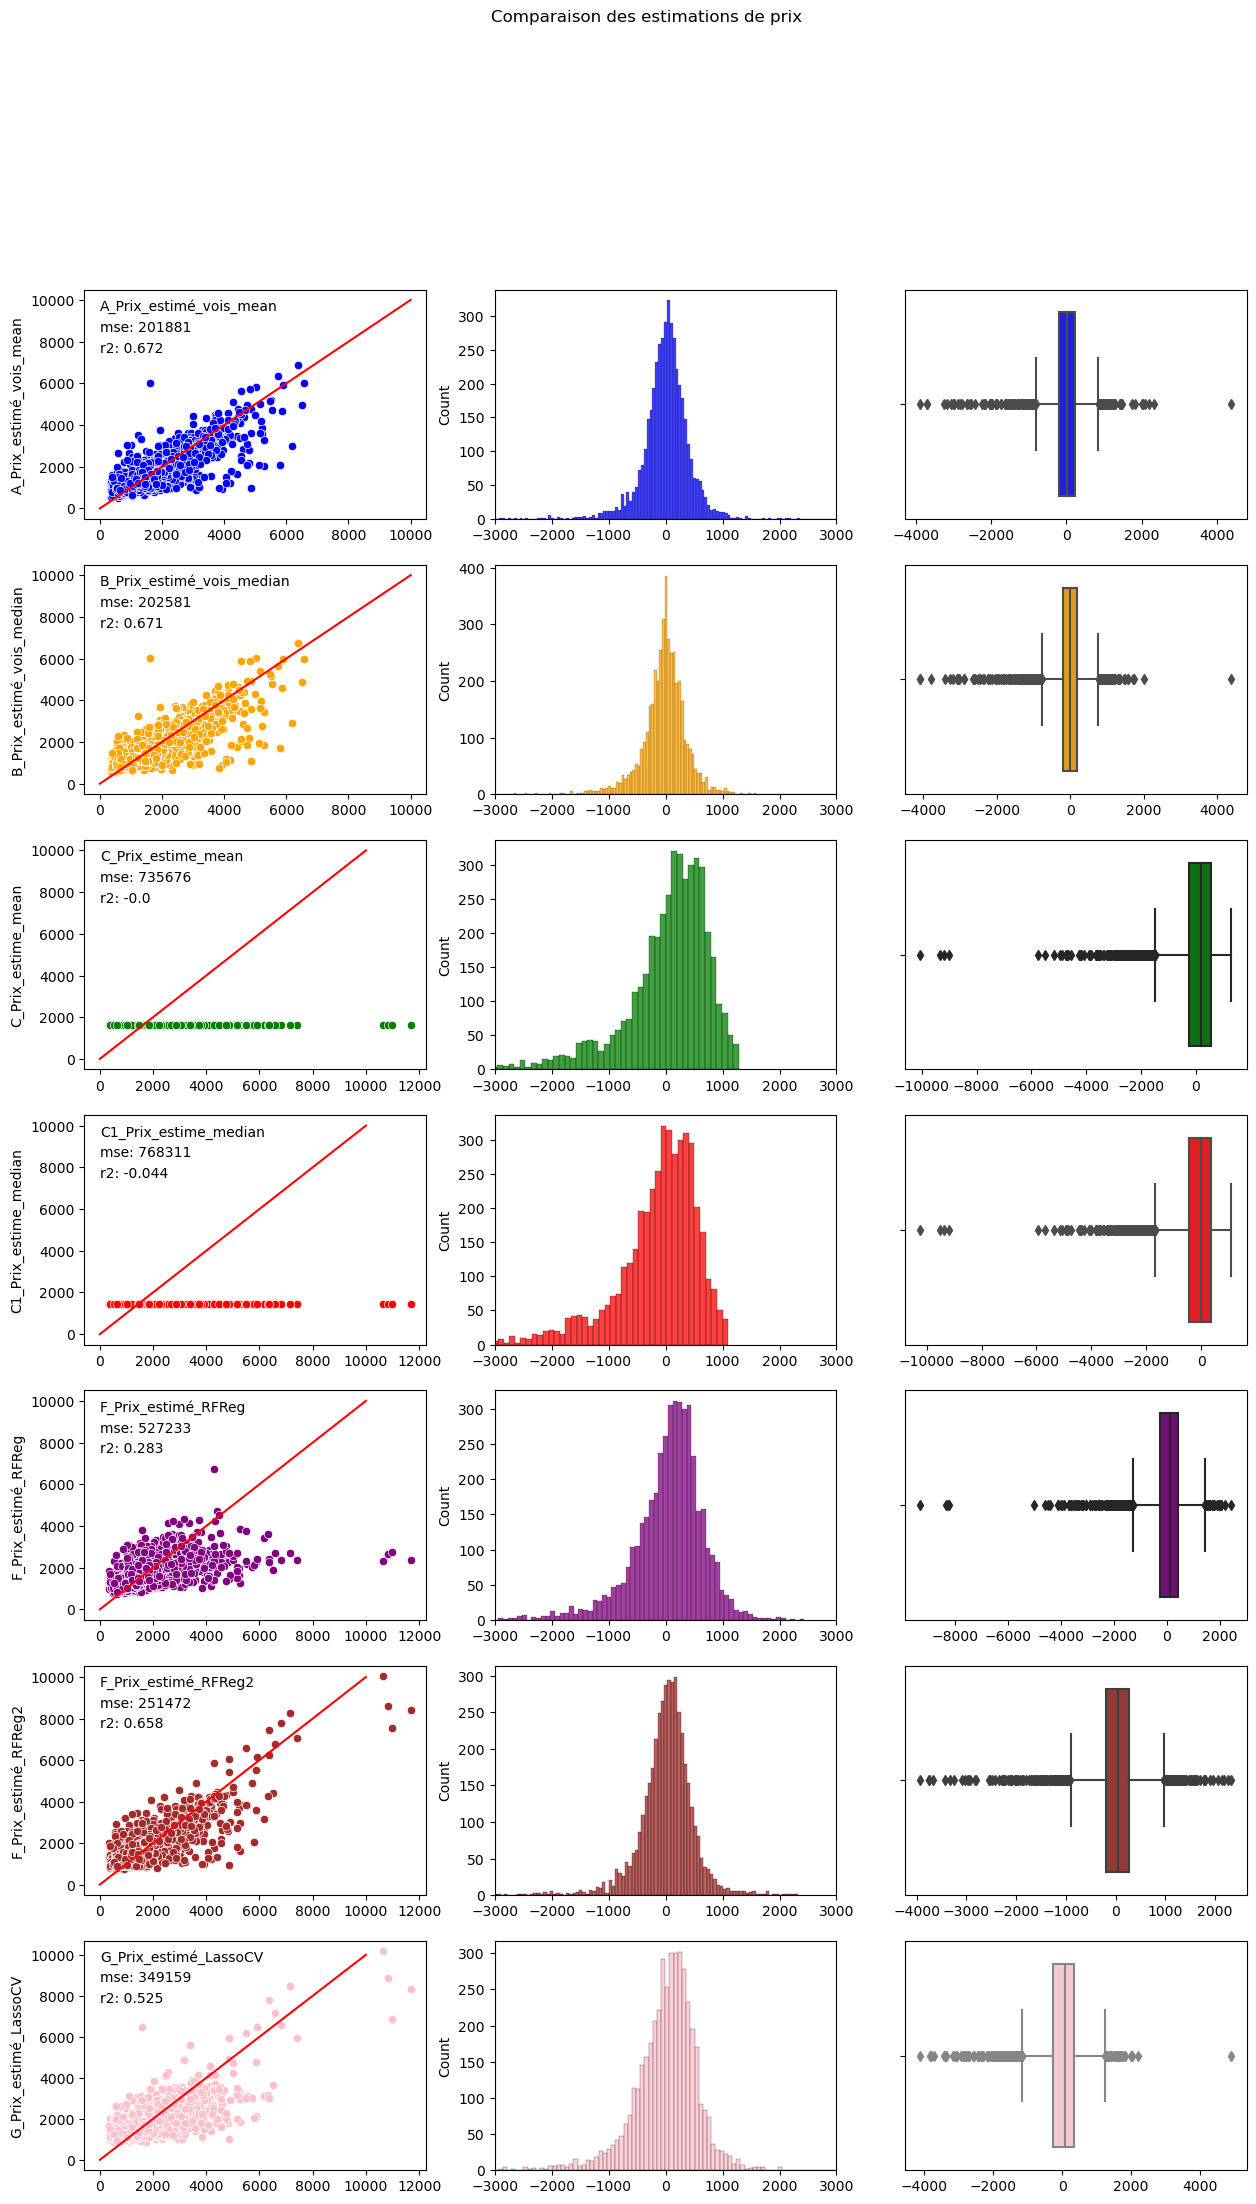

In [33]:
performance_of_simulations('Comparaison des estimations de prix',  
                           ['A_Prix_estimé_vois_mean', 'B_Prix_estimé_vois_median', 
                            'C_Prix_estime_mean', 'C1_Prix_estime_median',
                            'F_Prix_estimé_RFReg',  'F_Prix_estimé_RFReg2',
                            'G_Prix_estimé_LassoCV','D_Prix_estime_KNN' ,
                           ])